<a href="https://colab.research.google.com/github/dgomes03/assignments_ML/blob/main/Assignment2_Diogo_Gomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Assignment 2

**Diogo Gomes nº26843**

Consider the time series data set 'aquifer_time_series.csv' available at https://github.com/isa-ulisboa/greends-pml/tree/main/data with the following columns:

- 'date', in format DD/MM/YYYY
- 'rainfall_mm', precipitation in mm
- 'depth_to_groundwater_m', response variable (meters)
- 'temperature_C', temperature in Celsius
- 'drainage_m3', estimated drainage volume (cubic meters)
- 'river_hydrometry_m', river level height (meters)

The goal is to predict the value of 'depth_to_groundwater_m' for month K from the values of all variables at months K, K-1, ..., K-12 (except 'depth_to_groundwater_m' for month K, of course). Towards that end, it is recommended to preprocess the data in order to create a single value per month for each attribute (for instance using the median of the values for each attribute over each month).

This regression problem involves time series, so cross-validation has to be done using groups to guarantee that folds are not correlated.

You should create and fit a model (including preprocessing) for prediction. The code should be modular with a short main function. You should include in your script cross_val_score and StratifiedGroupKFold or GroupKFold, or some equivalent functionality.  For the regressor model you can use RandomForestRegressor.

You need to create a video (maximum 3'-5' ) where you describe your script and the results you obtained, where you should include an actual vs predicted plot. You should edit the video to include the following keywords as text over the video when you describe them. The 9 keywords to address are:  model input size, model output size, preprocessing, scaling, model, predict, cross-validation folds, cross-validation groups and evaluation metric.

Please submit the video (max 3'-5'), the URL of your notebook in your Github repository. One should be able to execute the code on Colab just by clicking the "Open in Colab" button and executing the notebook (see, for example, https://github.com/isa-ulisboa/greends-pml/blob/main/notebooks/iris_LM_inference.ipynb)

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


df = pd.read_csv("https://raw.githubusercontent.com/dgomes03/assignments_ML/1f021a9a70c16303fd9dc0b776589ab648a2a798/aquifer_time_series.csv")

df

,date,rainfall_mm,depth_to_groundwater_m,temperature_C,drainage_m3,river_hydrometry_m
0,14/03/2006,NaN,-22.18,NaN,NaN,NaN
1,15/03/2006,NaN,-22.14,NaN,NaN,NaN
2,16/03/2006,NaN,-22.04,NaN,NaN,NaN
3,17/03/2006,NaN,-22.04,NaN,NaN,NaN
4,18/03/2006,NaN,-22.04,NaN,NaN,NaN
...,...,...,...,...,...,...
5218,26/06/2020,0.0,-25.07,25.7,-29930.688,2.5
5219,27/06/2020,0.0,-25.11,26.2,-31332.960,2.4
5220,28/06/2020,0.0,-25.19,26.9,-32120.928,2.4
5221,29/06/2020,0.0,-25.18,26.9,-30602.880,2.4


### Exploring the dataset

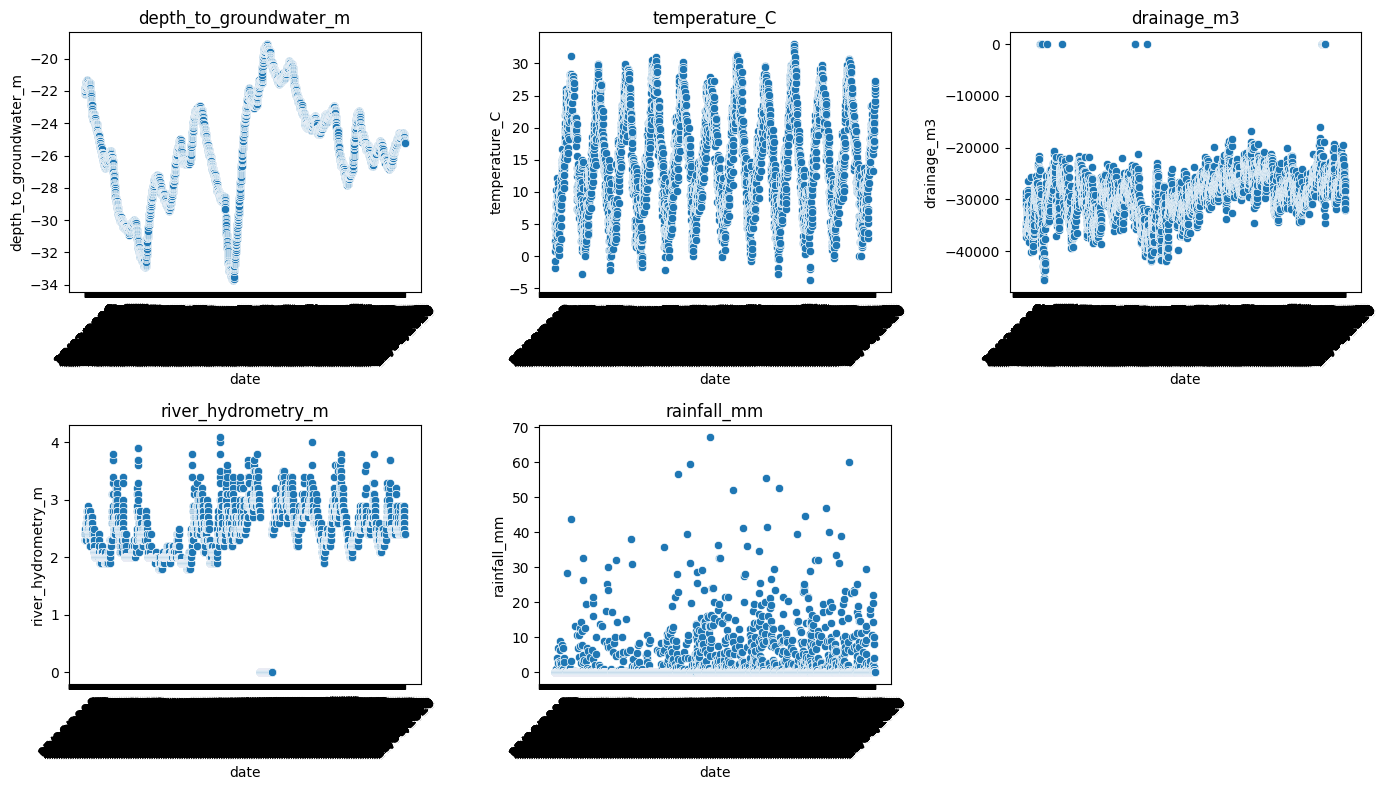

In [9]:
# Set up 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# List of columns to plot
columns = [
    'depth_to_groundwater_m',
    'temperature_C',
    'drainage_m3',
    'river_hydrometry_m',
    'rainfall_mm'
]

# Plot each variable
for ax, col in zip(axes.flat, columns):
    sns.scatterplot(x='date', y=col, data=df, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

# Hide the unused subplot
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()

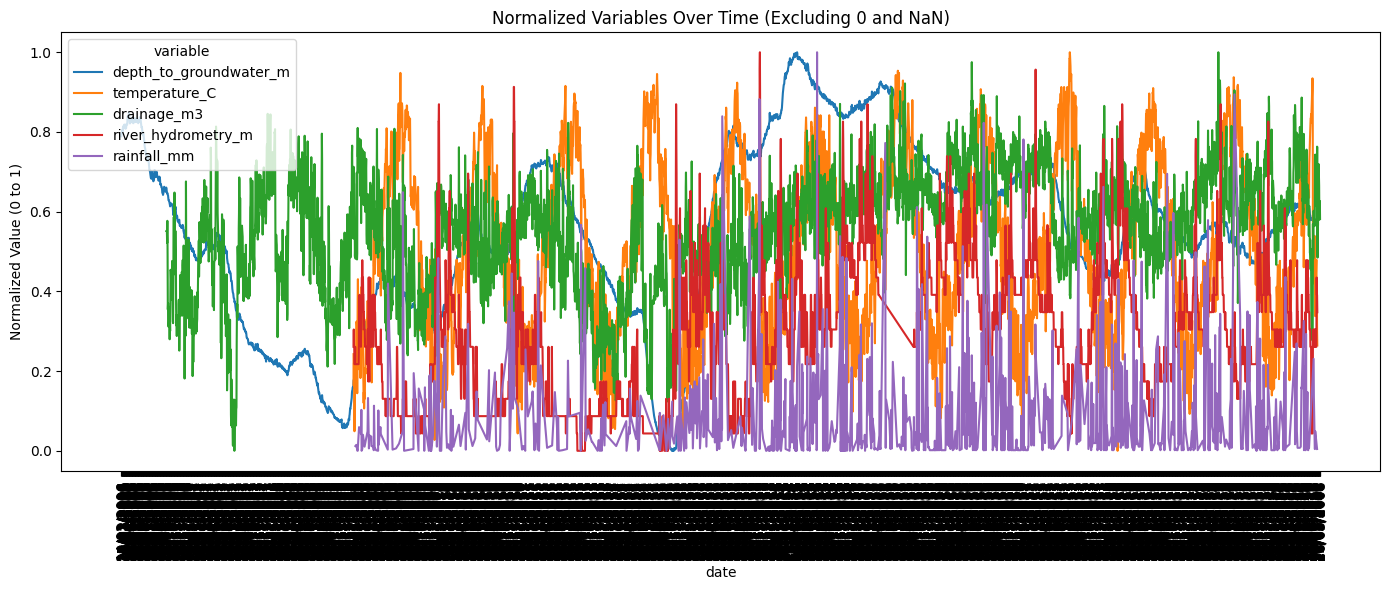

In [10]:
# Initialize a new DataFrame for normalized data
normalized_df = pd.DataFrame()
normalized_df['date'] = df['date']

# Normalize each column, ignoring NaNs and zeros
for col in columns:
    col_data = df[col]
    valid = (col_data != 0) & (col_data.notna())
    min_val = col_data[valid].min()
    max_val = col_data[valid].max()

    # Normalize only valid values; others become NaN
    normalized = (col_data - min_val) / (max_val - min_val)
    normalized[~valid] = None  # Set invalid entries to NaN

    normalized_df[col] = normalized

# Melt the dataframe for plotting
melted_df = normalized_df.melt(id_vars='date', value_vars=columns,
                                var_name='variable', value_name='value')

# Drop NaNs (from originally missing or zero values)
melted_df.dropna(inplace=True)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=melted_df, x='date', y='value', hue='variable')

plt.title('Normalized Variables Over Time (Excluding 0 and NaN)')
plt.ylabel('Normalized Value (0 to 1)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

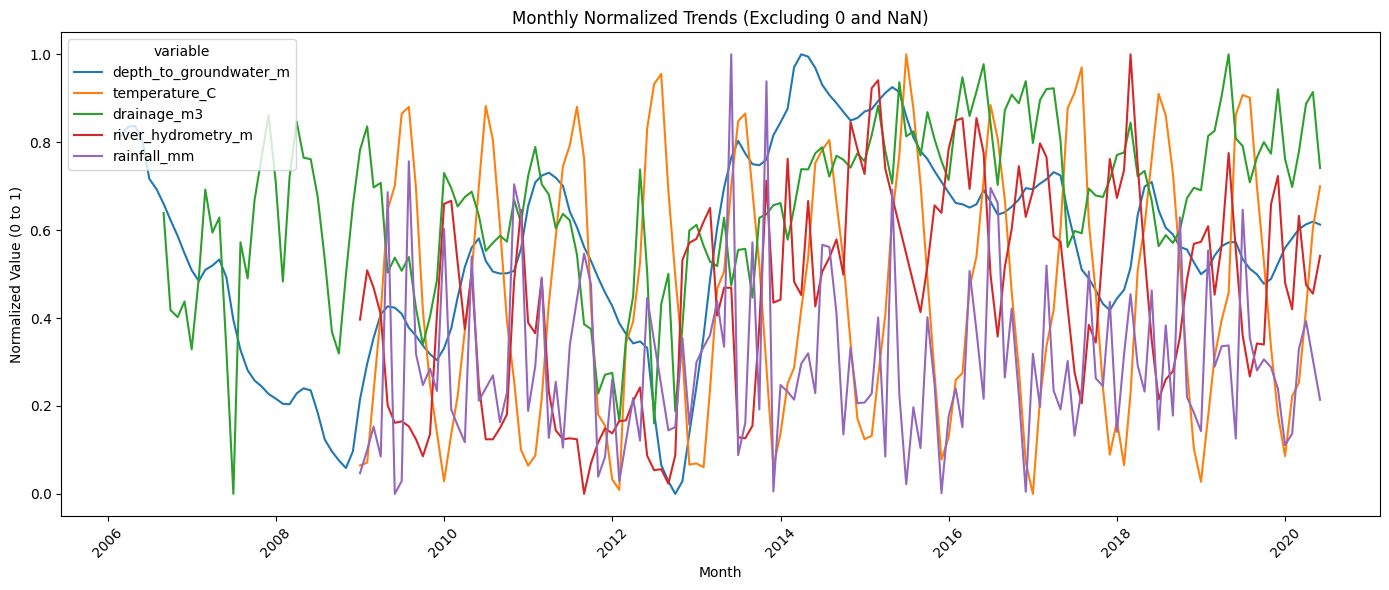

In [11]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Extract year-month for grouping
df['month'] = df['date'].dt.to_period('M')

# Columns to normalize and plot
columns = [
    'depth_to_groundwater_m',
    'temperature_C',
    'drainage_m3',
    'river_hydrometry_m',
    'rainfall_mm'
]

# Exclude 0 and NaN, then calculate monthly means
clean_df = df.copy()
for col in columns:
    clean_df[col] = clean_df[col].where((clean_df[col] != 0) & (clean_df[col].notna()), pd.NA)

monthly_mean = clean_df.groupby('month')[columns].mean().reset_index()
monthly_mean['month'] = monthly_mean['month'].dt.to_timestamp()

# Normalize each column independently
normalized_df = monthly_mean.copy()
for col in columns:
    col_data = monthly_mean[col]
    min_val = col_data.min()
    max_val = col_data.max()
    normalized_df[col] = (col_data - min_val) / (max_val - min_val)

# Melt for Seaborn plotting
melted = normalized_df.melt(id_vars='month', value_vars=columns, var_name='variable', value_name='value')

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=melted, x='month', y='value', hue='variable')

plt.title('Monthly Normalized Trends (Excluding 0 and NaN)')
plt.ylabel('Normalized Value (0 to 1)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Preprocessing

In [12]:
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, parse_dates=['date'], dayfirst=True)
    df['year_month'] = df['date'].dt.to_period('M')
    # substituir 0s por NaNs nas colunas necessárias uma vez que os 0 nao signficam na verdade 0 mas sim nan.
    cols_to_clean = ['river_hydrometry_m', 'drainage_m3', 'depth_to_groundwater_m']
    df[cols_to_clean] = df[cols_to_clean].replace(0, np.nan)
    monthly = df.groupby('year_month').median().reset_index()
    return monthly

### Lag features

In [13]:
def create_lag_features(df, n_lags=12):
    lagged_data = pd.DataFrame()
    feature_cols = [col for col in df.columns if col not in ['year_month', 'depth_to_groundwater_m']]

    for col in feature_cols:
        for lag in range(0, n_lags + 1):
            lagged_data[f'{col}_lag_{lag}'] = df[col].shift(lag)

    lagged_data['target'] = df['depth_to_groundwater_m']
    lagged_data['group'] = np.arange(len(lagged_data))
    lagged_data['date'] = df['year_month'].dt.to_timestamp()
    lagged_data = lagged_data.dropna()
    return lagged_data

### Train and evaluate results

Cross-validation MSE scores: [2.36738917 3.06667702 4.27804543 3.91601797 2.85059905]
Mean MSE: 3.2957457302272752


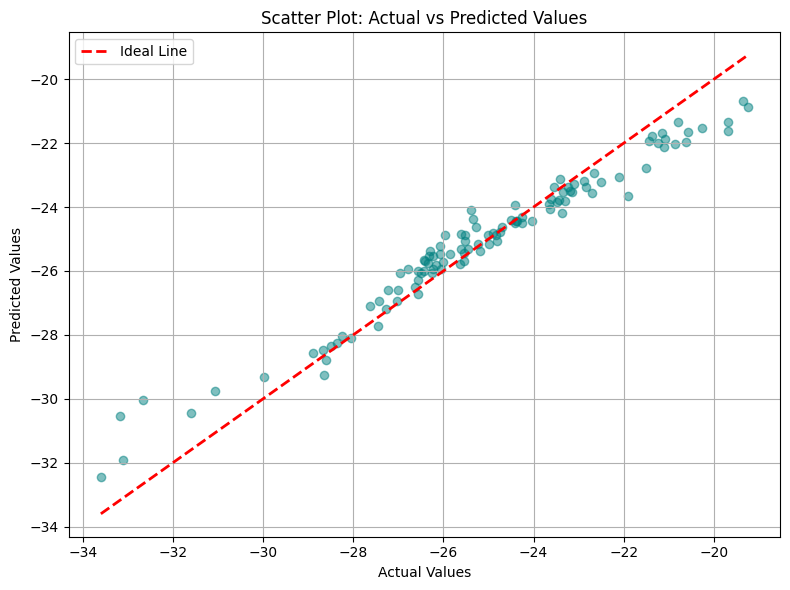

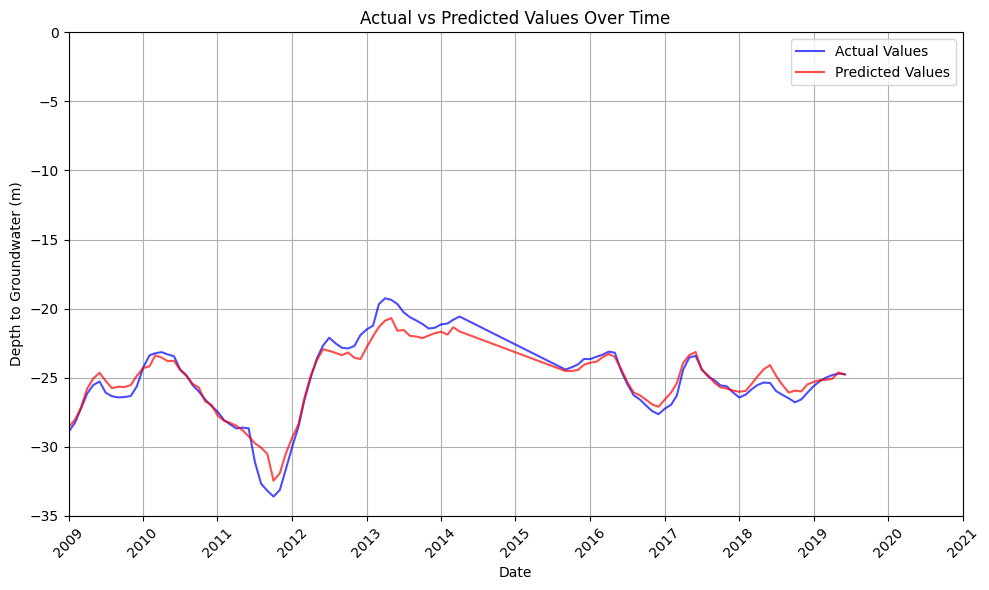

In [15]:
def build_model():
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    return model

def plot_scatter_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='teal')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot: Actual vs Predicted Values')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted_over_time(dates, y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_true, label='Actual Values', color='blue', alpha=0.7)
    plt.plot(dates, y_pred, label='Predicted Values', color='red', alpha=0.7)
    plt.title('Actual vs Predicted Values Over Time')
    plt.xlabel('Date')
    plt.xlim(pd.to_datetime('2009-12-31'), pd.to_datetime('2021-01-01'))
    plt.xticks(pd.date_range(start='2009-12-31', end='2021-12-31', freq='YE'), rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.ylabel('Depth to Groundwater (m)')
    plt.ylim(-35, 0)
    plt.yticks(np.arange(-35, 1, 5))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    filepath = "https://raw.githubusercontent.com/dgomes03/assignments_ML/1f021a9a70c16303fd9dc0b776589ab648a2a798/aquifer_time_series.csv"
    monthly_data = load_and_preprocess_data(filepath)

    data = create_lag_features(monthly_data)

    # definir X e y (model input e output)
    X = data.drop(columns=['target', 'group', 'date'])
    y = data['target']
    groups = data['group']
    dates = data['date']

    X = X.select_dtypes(include=[np.number])

    model = build_model()

    # Cross-validation
    cv = GroupKFold(n_splits=5)
    scores = cross_val_score(model, X, y, groups=groups, cv=cv, scoring='neg_mean_squared_error')
    print("Cross-validation MSE scores:", -scores)
    print("Mean MSE:", -scores.mean())

    # treinar modelo no dataset todo
    model.fit(X, y)

    # fazer predict
    y_pred = model.predict(X)

    # plots
    plot_scatter_actual_vs_predicted(y, y_pred)
    plot_actual_vs_predicted_over_time(dates, y, y_pred)

if __name__ == "__main__":
    main()